# Univariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from metrics import MetricsLogger
from data_loaders import get_wake_dataloaders

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
DATAFRAME_FILEPATH = "data/discr_factors_x2_50_y-1_1_step0.125/"
BEST_MODEL_PATH = "models/univariate_NN"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# hyperparameters
BATCH_SIZE = 512
EPOCHS = 10
LR = 0.0000001

In [3]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATAFRAME_FILEPATH,
                                                          consider_ws=False,
                                                          coords_as_input=True,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader)

15480

In [7]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

torch.Size([512, 4]) torch.Size([512, 1])


input_space=4	output_space=1
Logging UnivariateNN training
Epoch 0 ->	Training loss=0.0017251786189523793	Validation loss=0.001865712383226507	
Epoch 1 ->	Training loss=0.0015242513018400494	Validation loss=0.0015463453961166395	
Epoch 2 ->	Training loss=0.0011867694447479735	Validation loss=0.0011989954243415185	
Epoch 3 ->	Training loss=0.0009490704667463509	Validation loss=0.0009941767649858126	
Epoch 4 ->	Training loss=0.0008210195153695577	Validation loss=0.0008819745984047605	
Epoch 5 ->	Training loss=0.0007447561540118826	Validation loss=0.0008100857589449932	
Epoch 6 ->	Training loss=0.0006929000773656186	Validation loss=0.0007582665620418514	
Epoch 7 ->	Training loss=0.0006532718352143964	Validation loss=0.0007171880254712116	
Epoch 8 ->	Training loss=0.0006206058676016772	Validation loss=0.0006830566131274761	
Epoch 9 ->	Training loss=0.0005924692351183191	Validation loss=0.0006529815111142612	

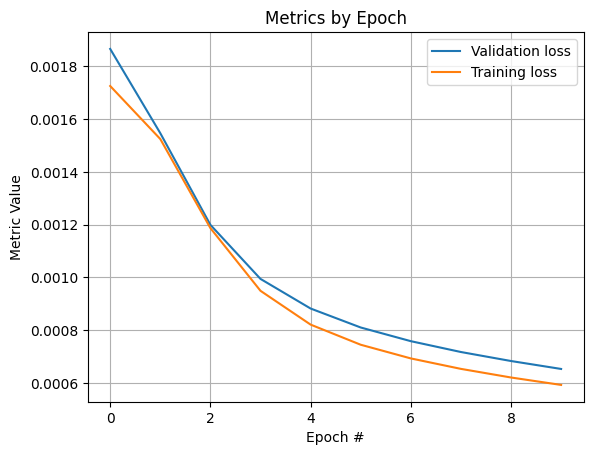

Metrics exported in the following csv file: logged_metrics/UnivariateNNtraining_metrics_19-05-2023_18-42-39.csv


In [5]:
input_space = train_dataloader.dataset.x.shape[1]
output_space = train_dataloader.dataset.y.shape[1]
print(f"{input_space=}\t{output_space=}")

class UnivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(UnivariateNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_space, 50),
            nn.ReLU(),
            nn.Linear(50, 250),
            nn.ReLU(),
            nn.Linear(250, output_space),
            nn.ReLU() #TODO?
        )

    def forward(self, x):
        return self.layers(x)

model = UnivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name="UnivariateNN training")
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model(x)
        tloss = loss_function(prediction, y)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item()
        #TODO accuracy or other metric computation????

    avg_tloss = epoch_tloss / len(train_dataloader)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(x)
            vloss = loss_function(prediction, y)

            epoch_vloss += vloss.item()

        avg_vloss = epoch_vloss / len(valid_dataloader)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), BEST_MODEL_PATH)


metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Testing

In [6]:
# loading best one

model = UnivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.train(False)

total_loss = 0
with torch.no_grad():
    for batch in iter(test_dataloader):
        # to device
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)

        prediction = model(x)
        tloss = loss_function(prediction, y)

        total_loss += tloss.item()

avg_loss = total_loss / len(test_dataloader) / BATCH_SIZE #TODO
print(f"Testing results: avg loss={avg_loss}")


Testing results: avg loss=1.0457808373501256e-06
